In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, DotProduct, ConstantKernel as C
import seaborn as sns
from math import sqrt
import matplotlib.pyplot as plt

In [2]:
#import dataset
creep_df = pd.read_csv('../Data/Ti_alloys_dataset.csv')
creep_df

,Ti,Al,V,Fe,C,N,H,O,Sn,Nb,...,Cr,Solution treated temp(cel),ST time (h),Anneal temp (cel),Annealing Time (hour),Temperature of creep test (cel),Stress (Mpa),steady state strain rate (1/s),Strain to rupture (%) (Efc),creep_rupture_life
0,87.8750,6.75,4.50,0.40,0.100,0.050,0.1250,0.20,0.00,0.0,...,0.0,690,4.0,1050,0.5,700,319.0,2.090000e-03,15.80,0.01000
1,87.8100,6.61,4.23,1.18,0.026,0.011,0.0030,0.13,0.00,0.0,...,0.0,0,0.0,0,0.0,600,319.0,3.240000e-06,0.00,0.01167
2,87.8100,6.61,4.23,1.18,0.026,0.011,0.0030,0.13,0.00,0.0,...,0.0,0,0.0,0,0.0,600,250.0,4.400000e-05,0.00,0.03050
3,87.8100,6.61,4.23,1.18,0.026,0.011,0.0030,0.13,0.00,0.0,...,0.0,0,0.0,0,0.0,500,520.0,4.430000e-05,0.00,0.04620
4,87.8100,6.61,4.23,1.18,0.026,0.011,0.0030,0.13,0.00,0.0,...,0.0,0,0.0,0,0.0,700,319.0,2.130000e-03,0.00,0.05000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,85.9870,6.20,0.00,0.00,0.021,0.004,0.0080,0.03,1.95,0.0,...,0.0,900,1.0,580,8.0,520,310.0,1.200000e-04,0.00,1160.00000
173,89.0434,6.51,4.08,0.16,0.010,0.005,0.0016,0.19,0.00,0.0,...,0.0,0,0.0,940,4.0,455,379.0,9.160000e-07,0.00,1619.00000
174,89.0434,6.51,4.08,0.16,0.010,0.005,0.0016,0.19,0.00,0.0,...,0.0,0,0.0,1030,0.5,455,379.0,1.270000e-06,0.00,1744.00000
175,89.4100,6.00,4.00,0.25,0.080,0.050,0.0100,0.20,0.00,0.0,...,0.0,0,0.0,0,0.0,538,103.0,9.000000e-07,22.30,4681.00000


In [3]:
creep_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177 entries, 0 to 176
Data columns (total 24 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Ti                               177 non-null    float64
 1   Al                               177 non-null    float64
 2   V                                177 non-null    float64
 3   Fe                               177 non-null    float64
 4   C                                177 non-null    float64
 5   N                                177 non-null    float64
 6   H                                177 non-null    float64
 7   O                                177 non-null    float64
 8   Sn                               177 non-null    float64
 9   Nb                               177 non-null    float64
 10  Mo                               177 non-null    float64
 11  Zr                               177 non-null    float64
 12  Si                    

In [4]:
features = creep_df.iloc[:, 0:23]
targets = np.log10(creep_df.iloc[:, 23])
features

,Ti,Al,V,Fe,C,N,H,O,Sn,Nb,...,B,Cr,Solution treated temp(cel),ST time (h),Anneal temp (cel),Annealing Time (hour),Temperature of creep test (cel),Stress (Mpa),steady state strain rate (1/s),Strain to rupture (%) (Efc)
0,87.8750,6.75,4.50,0.40,0.100,0.050,0.1250,0.20,0.00,0.0,...,0.00,0.0,690,4.0,1050,0.5,700,319.0,2.090000e-03,15.80
1,87.8100,6.61,4.23,1.18,0.026,0.011,0.0030,0.13,0.00,0.0,...,0.00,0.0,0,0.0,0,0.0,600,319.0,3.240000e-06,0.00
2,87.8100,6.61,4.23,1.18,0.026,0.011,0.0030,0.13,0.00,0.0,...,0.00,0.0,0,0.0,0,0.0,600,250.0,4.400000e-05,0.00
3,87.8100,6.61,4.23,1.18,0.026,0.011,0.0030,0.13,0.00,0.0,...,0.00,0.0,0,0.0,0,0.0,500,520.0,4.430000e-05,0.00
4,87.8100,6.61,4.23,1.18,0.026,0.011,0.0030,0.13,0.00,0.0,...,0.00,0.0,0,0.0,0,0.0,700,319.0,2.130000e-03,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,85.9870,6.20,0.00,0.00,0.021,0.004,0.0080,0.03,1.95,0.0,...,0.00,0.0,900,1.0,580,8.0,520,310.0,1.200000e-04,0.00
173,89.0434,6.51,4.08,0.16,0.010,0.005,0.0016,0.19,0.00,0.0,...,0.00,0.0,0,0.0,940,4.0,455,379.0,9.160000e-07,0.00
174,89.0434,6.51,4.08,0.16,0.010,0.005,0.0016,0.19,0.00,0.0,...,0.00,0.0,0,0.0,1030,0.5,455,379.0,1.270000e-06,0.00
175,89.4100,6.00,4.00,0.25,0.080,0.050,0.0100,0.20,0.00,0.0,...,0.00,0.0,0,0.0,0,0.0,538,103.0,9.000000e-07,22.30


In [5]:
def coverage(y, yL, yH):
    return np.sum(100 / y.shape[0] * ((y>yL)&(y<yH)))

Run # 1 Fold # 1


c:\Users\L\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Pearson CC: 0.9441347893383992
R2 score: 0.8789496746697607
RMSE: 0.3562935787740208
MAE: 0.2478193013822363
Coverage: 99.99999999999997
Pearson R2 median: 0.9441347893383992
R2 median: 0.8789496746697607
RMSE median: 0.3562935787740208
Interval Width: 1.811157623086233
Composite Metric: 0.8880332649203644


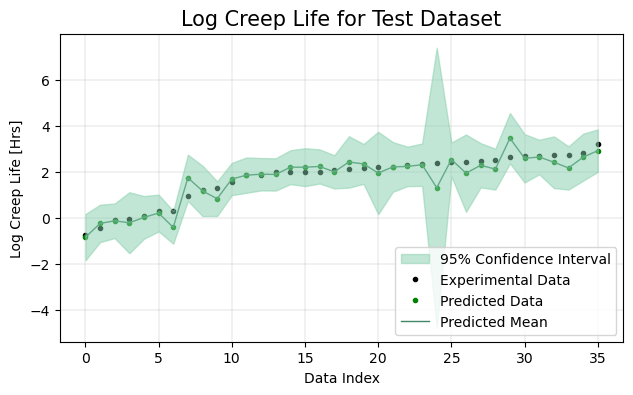

********************
Run # 1 Fold # 2


c:\Users\L\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Pearson CC: 0.7781417776803812
R2 score: 0.6003209020821259
RMSE: 0.8519557556720179
MAE: 0.46207441578003977
Coverage: 91.66666666666664
Pearson R2 median: 0.7781417776803812
R2 median: 0.6003209020821259
RMSE median: 0.8519557556720179
Interval Width: 1.7915595638753676
Composite Metric: 0.8270432253780156


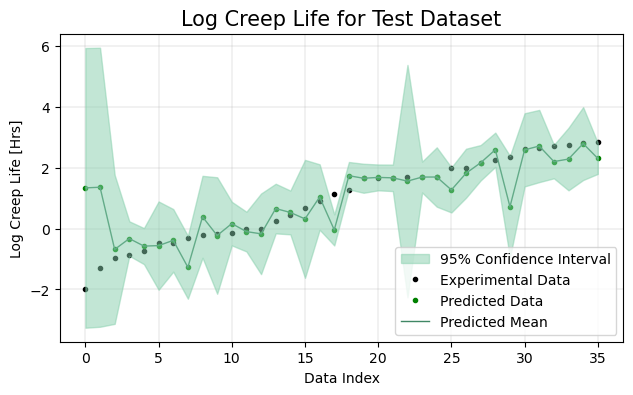

********************
Run # 1 Fold # 3


c:\Users\L\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\L\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Pearson CC: 0.9324120772964337
R2 score: 0.8582886374065857
RMSE: 0.471164659056448
MAE: 0.30462285374132186
Coverage: 94.2857142857143
Pearson R2 median: 0.9324120772964337
R2 median: 0.8582886374065857
RMSE median: 0.471164659056448
Interval Width: 1.5777895065260554
Composite Metric: 0.865592383499795


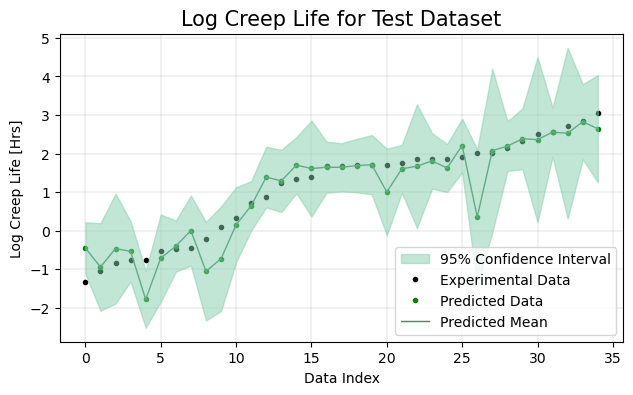

********************
Run # 1 Fold # 4


c:\Users\L\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\L\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Pearson CC: 0.9341792621994734
R2 score: 0.8693941084210786
RMSE: 0.4433561841569934
MAE: 0.28961270926885535
Coverage: 91.42857142857144
Pearson R2 median: 0.9341792621994734
R2 median: 0.8693941084210786
RMSE median: 0.4433561841569934
Interval Width: 1.4376251792859602
Composite Metric: 0.8596121859473425


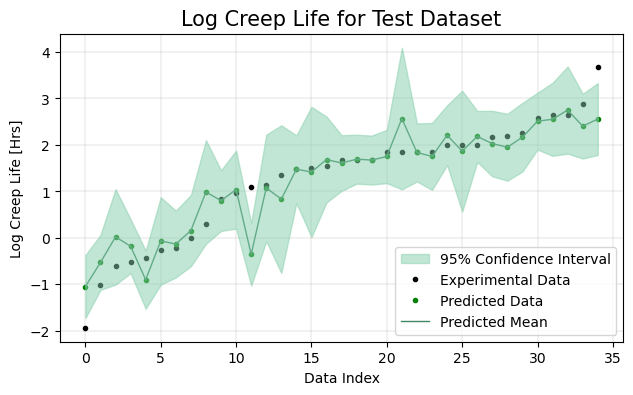

********************
Run # 1 Fold # 5


c:\Users\L\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Pearson CC: 0.9059987981491991
R2 score: 0.8017523841244083
RMSE: 0.45415518333981253
MAE: 0.31799471178545646
Coverage: 88.57142857142858
Pearson R2 median: 0.9059987981491991
R2 median: 0.8017523841244083
RMSE median: 0.45415518333981253
Interval Width: 1.5642903116945794
Composite Metric: 0.8241025961848152


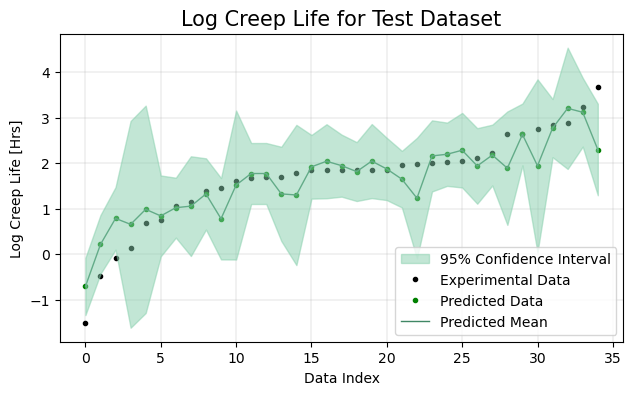

********************


In [6]:
# Evaluate multiple runs of the model
nruns = 1
nfolds = 5

PearsonCC = np.zeros((nruns, nfolds))
R2_score = np.zeros_like(PearsonCC)
RMSE = np.zeros_like(PearsonCC)
MAE = np.zeros_like(PearsonCC)

test_coverage = np.zeros_like(PearsonCC)
median_interval_width = np.zeros_like(PearsonCC)
composite_metric = np.zeros_like(PearsonCC)

for j in range(nruns):

        kf = KFold(n_splits=nfolds, shuffle=True, random_state=123+j)

        kernel = C(1.0) * Matern(length_scale=1.0) + WhiteKernel(noise_level=1.0) + C(1.0) * DotProduct(sigma_0=1.0)

        for i, (tr, ts) in enumerate(kf.split(targets)):

            # Display the run number
            print('Run #', j+1, "Fold #", i+1)

            X_train, X_test = features.iloc[tr], features.iloc[ts]
            y_train, y_test = targets[tr], targets[ts]

            scale = MinMaxScaler()
            X_train = scale.fit_transform(X_train)
            X_test = scale.transform(X_test)

            model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=8, normalize_y=True)

            model.fit(X_train, y_train)

            mu_z, std_z = model.predict(X_test, return_std=True)
            y_pred_test = mu_z
            y_pred_unc_test = std_z

            PearsonCC[j, i] = pearsonr(y_test, y_pred_test)[0]
            R2_score[j, i] = r2_score(y_test, y_pred_test)
            RMSE[j, i] = sqrt(mean_squared_error(y_pred_test, y_test))
            MAE[j, i] = np.mean(abs(y_pred_test-y_test))

            df_test_low = y_pred_test - 2 * y_pred_unc_test
            df_test_median = y_pred_test
            df_test_high = y_pred_test + 2 * y_pred_unc_test

            test_coverage[j, i] = coverage(y_test, df_test_low, df_test_high)

            print(f'Pearson CC: {PearsonCC[j, i]}')
            print(f'R2 score: {R2_score[j, i]}')
            print(f'RMSE: {RMSE[j, i]}')
            print(f'MAE: {MAE[j, i]}')
            print(f'Coverage: {test_coverage[j, i]}')

            print(f"Pearson R2 median: {pearsonr(y_test, df_test_median)[0]}")
            print(f"R2 median: {r2_score(y_test, df_test_median)}")
            print(f"RMSE median: {np.sqrt(mean_squared_error(y_test, df_test_median))}")
            
            # Prediction interval width
            # Quantifies the average width of the prediction intervals. Smaller widths suggest more precise uncertainty estimates.

            median_interval_width[j, i] = np.median(df_test_high - df_test_low)
            print(f'Interval Width: {median_interval_width[j, i]}')

            # Composite metric that combines the coverage and the invers of interval width
            composite_metric[j, i] = 0.75*test_coverage[j, i]/100 + 0.25*(1/median_interval_width[j, i])
            print(f'Composite Metric: {composite_metric[j, i]}')

            y_pred = y_pred_test
            y_std = y_pred_unc_test
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
            iteration_list = [i for i in range(len(y_test))]
            ## Uncertainty quantification plot
            ax[0].fill_between(iteration_list, np.squeeze(y_pred) - 2*np.squeeze(y_std), np.squeeze(y_pred) + 2*np.squeeze(y_std), alpha=0.5, color='#86cfac', zorder=5, label='95% Confidence Interval')
            ax[0].plot(iteration_list, y_test, 'ko', markersize=3, label="Experimental Data")
            ax[0].plot(iteration_list, np.squeeze(y_pred), 'go', markersize=3, label="Predicted Data")
            ax[0].plot(iteration_list, y_pred, '-', linewidth=1, color="#408765", label="Predicted Mean")
            ax[0].legend(loc=4, fontsize=10, frameon=True)
            ax[0].set_xlabel("Data Index", fontsize=10)
            ax[0].set_ylabel("Log Creep Life [Hrs]", fontsize=10)
            ax[0].set_title("Log Creep Life for Test Dataset", fontsize=15)
            ax[0].grid(True, which='major', linestyle='-', linewidth='0.25')
            fig.delaxes(ax[1])

            plt.show()

            print(20*'*')

In [7]:
# Data frame
df1 = pd.DataFrame({'Pearson CC': PearsonCC.flatten(), 'R2 Score': R2_score.flatten(), 'RMSE': RMSE.flatten(),
                    'MAE': MAE.flatten(), 'Coverage': test_coverage.flatten()},index=None)
df1

,Pearson CC,R2 Score,RMSE,MAE,Coverage
0,0.944135,0.878950,0.356294,0.247819,100.000000
1,0.778142,0.600321,0.851956,0.462074,91.666667
2,0.932412,0.858289,0.471165,0.304623,94.285714
3,0.934179,0.869394,0.443356,0.289613,91.428571
4,0.905999,0.801752,0.454155,0.317995,88.571429


In [8]:
# Calculate mean values and standard deviations of the scores
PearsonCC_mean = np.mean(PearsonCC)
R2_score_mean = np.mean(R2_score)
RMSE_mean = np.mean(RMSE)
MAE_mean = np.mean(MAE)
test_coverage_mean = np.mean(test_coverage)

PearsonCC_std = np.std(PearsonCC)
R2_score_std = np.std(R2_score)
RMSE_std = np.std(RMSE)
MAE_std = np.std(MAE)
test_coverage_std = np.std(test_coverage)

# Data frame
df2 = pd.DataFrame({'Pearson CC Mean': PearsonCC_mean, 'Pearson CC Std': PearsonCC_std, 'R2 Score Mean': R2_score_mean, 'R2 Score Std': R2_score_std,
                  'RMSE Mean': RMSE_mean, 'RMSE Std': RMSE_std, 'MAE Mean': MAE_mean, 'MAE Std':MAE_std,
                   'RMSE Std': RMSE_std, 'Test Coverage Mean': test_coverage_mean, 'Test Coverage Std':test_coverage_std},index=[0])
df2

,Pearson CC Mean,Pearson CC Std,R2 Score Mean,R2 Score Std,RMSE Mean,RMSE Std,MAE Mean,MAE Std,Test Coverage Mean,Test Coverage Std
0,0.898973,0.06172,0.801741,0.104217,0.515385,0.172906,0.324425,0.072748,93.190476,3.855673


In [9]:
# Data frame
df3 = pd.DataFrame({'Coverage': test_coverage.flatten(),  'Interval Width': median_interval_width.flatten(), 'Composite Metric': composite_metric.flatten()},index=None)
df3

,Coverage,Interval Width,Composite Metric
0,100.000000,1.811158,0.888033
1,91.666667,1.791560,0.827043
2,94.285714,1.577790,0.865592
3,91.428571,1.437625,0.859612
4,88.571429,1.564290,0.824103


In [10]:
# Calculate mean values and standard deviations of the scores
test_coverage_mean = np.mean(test_coverage)
median_interval_width_mean = np.mean(median_interval_width)
composite_metric_mean = np.mean(composite_metric)

test_coverage_std = np.std(test_coverage)
median_interval_width_std = np.std(median_interval_width)
composite_metric_std = np.std(composite_metric)

# Data frame
df4 = pd.DataFrame({'Coverage Mean': test_coverage_mean, 'Coverage Std': test_coverage_std,
                    'Interval Width Mean': median_interval_width_mean, 'Interval Width Std':median_interval_width_std,
                   'Composite Metric Mean': composite_metric_mean, 'Composite Metric Std': composite_metric_std,},index=[0])
df4

,Coverage Mean,Coverage Std,Interval Width Mean,Interval Width Std,Composite Metric Mean,Composite Metric Std
0,93.190476,3.855673,1.636484,0.14336,0.852877,0.024242
